In [1]:
import pandas as pd
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np
from sksurv.nonparametric import kaplan_meier_estimator

In [16]:
# Separate classifications of “return to normal” will be created for taste and for smell.
# We will a) perform survival analysis for chemosensory long haulers, using time in days between the date of onset of initial symptoms and the completion day of the follow-up survey.
# We will also b) use linear regression to predict the difference score using the degree of loss in an initial survey and in a follow-up survey, controlling for time passed between the two surveys.

data = pd.read_csv(r'C:/Users/asus/Desktop/tubitak_project/GCCR/GCCR 3 data analysis/gccr 3/aim1/gccr003_data_covid.csv',sep=';',encoding='unicode_escape')

In [17]:
data["Date_of_onset"] = pd.to_datetime(data["Date_of_onset"], dayfirst=True)
data["Email_Time_Stamp_y"] = pd.to_datetime(data["Email_Time_Stamp_y"], dayfirst=True)

In [18]:
data = data.dropna(subset=['Date_of_onset', 'Email_Time_Stamp_y'])
data['DurationInDays'] = ((data['Email_Time_Stamp_y'] - data['Date_of_onset']).dt.total_seconds() / (60 * 60 * 24))

In [19]:
data = data[data['Date_of_onset'].dt.year > 2018] # Include data after COVID

In [20]:
data.head()

,Sample_Set_Number_x,Date_of_onset,DurationInDays,Smell_before_illness,Smell_during_illness,Smell_after_illness,Smell_current,Taste_before_illness,Taste_during_illness,Taste_after_illness,Taste_current,Email_Time_Stamp_y,Status,COVID_diagnosis_y
0,1996,2020-03-14,194.604861,89.5,4.A§u,"44205,00","31,00",93.4,"44205,00","44459,00",33.7,2020-09-24 14:31:00,0,"2,00"
1,875,2020-03-26,182.605556,99.1,0.3,34.4,"44468,00",99.7,46.2,"44310,00",NaN,2020-09-24 14:32:00,0,"1,00"
2,5862,2020-04-08,169.606250,98.1,99.8,"0,00",47.5,100,"100,00","0,00",48.5,2020-09-24 14:33:00,0,"3,00"
3,5321,2020-03-05,203.608333,"100,00","0,00","65,00",99.6,86.4,"4,00","72,00",88.1,2020-09-24 14:36:00,0,"1,00"
4,4225,2020-04-02,175.609028,98.5,0.6,NaN,"100,00",98.5,"0,00",NaN,"100,00",2020-09-24 14:37:00,0,"2,00"


In [24]:
data["Smell_before_illness"] = pd.to_numeric(data.Smell_before_illness, errors='coerce')
data["Smell_during_illness"] = pd.to_numeric(data.Smell_during_illness, errors='coerce')
data["Smell_after_illness"] = pd.to_numeric(data.Smell_after_illness, errors='coerce')
data["Smell_current"] = pd.to_numeric(data.Smell_current, errors='coerce')
data["Taste_before_illness"] = pd.to_numeric(data.Taste_before_illness, errors='coerce')
data["Taste_during_illness"] = pd.to_numeric(data.Taste_during_illness, errors='coerce')
data["Taste_after_illness"] = pd.to_numeric(data.Taste_after_illness, errors='coerce')
data["Taste_current"] = pd.to_numeric(data.Taste_current, errors='coerce')

data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3052 entries, 0 to 3391
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Sample_Set_Number_x   3052 non-null   int64         
 1   Date_of_onset         3052 non-null   datetime64[ns]
 2   DurationInDays        3052 non-null   float64       
 3   Smell_before_illness  1925 non-null   float64       
 4   Smell_during_illness  683 non-null    float64       
 5   Smell_after_illness   1230 non-null   float64       
 6   Smell_current         2044 non-null   float64       
 7   Taste_before_illness  3018 non-null   float64       
 8   Taste_during_illness  946 non-null    float64       
 9   Taste_after_illness   1501 non-null   float64       
 10  Taste_current         2233 non-null   float64       
 11  Email_Time_Stamp_y    3052 non-null   datetime64[ns]
 12  Status                3052 non-null   int64         
 13  COVID_diagnosis_y 

,Sample_Set_Number_x,Date_of_onset,DurationInDays,Smell_before_illness,Smell_during_illness,Smell_after_illness,Smell_current,Taste_before_illness,Taste_during_illness,Taste_after_illness,Taste_current,Email_Time_Stamp_y,Status,COVID_diagnosis_y
0,1996,2020-03-14,194.604861,89.5,NaN,NaN,NaN,93.4,NaN,NaN,33.7,2020-09-24 14:31:00,0,"2,00"
1,875,2020-03-26,182.605556,99.1,0.3,34.4,NaN,99.7,46.2,NaN,NaN,2020-09-24 14:32:00,0,"1,00"
2,5862,2020-04-08,169.606250,98.1,99.8,NaN,47.5,100.0,NaN,NaN,48.5,2020-09-24 14:33:00,0,"3,00"
3,5321,2020-03-05,203.608333,NaN,NaN,NaN,99.6,86.4,NaN,NaN,88.1,2020-09-24 14:36:00,0,"1,00"
4,4225,2020-04-02,175.609028,98.5,0.6,NaN,NaN,98.5,NaN,NaN,NaN,2020-09-24 14:37:00,0,"2,00"


In [33]:
data=data[data['COVID_diagnosis_y']=='2,00']
data.describe()

,Sample_Set_Number_x,DurationInDays,Smell_before_illness,Smell_during_illness,Smell_after_illness,Smell_current,Taste_before_illness,Taste_during_illness,Taste_after_illness,Taste_current,Status
count,1440.000000,1440.000000,853.000000,310.000000,503.000000,956.000000,1424.000000,447.000000,636.000000,1068.000000,1440.0
mean,4232.245139,216.725236,89.554396,11.050323,56.015507,70.985774,93.693750,37.643624,62.906447,77.403184,0.0
std,2507.963648,62.046277,11.794214,24.708819,29.060261,19.489579,9.098789,32.147902,24.180962,18.590254,0.0
min,9.000000,36.748611,31.900000,0.100000,0.100000,0.200000,0.500000,0.100000,0.100000,0.200000,0.0
25%,2088.250000,183.905903,85.300000,0.300000,41.600000,56.775000,90.500000,0.600000,48.550000,67.100000,0.0
50%,4230.000000,223.518056,93.400000,0.500000,60.300000,73.500000,97.900000,42.700000,65.550000,81.700000,0.0
75%,5957.750000,263.749826,98.200000,0.900000,77.750000,86.300000,100.000000,64.600000,81.100000,92.100000,0.0
max,9940.000000,327.100000,99.900000,99.700000,99.800000,99.900000,100.000000,99.700000,99.900000,99.900000,0.0


In [34]:
# create new dataframe variables
smell_df = data[['DurationInDays', 'Smell_before_illness', 'Smell_current', 'Status']]
taste_df = data[['DurationInDays', 'Taste_before_illness', 'Taste_current', 'Status']]

In [35]:
# drop nan records
smell_df = smell_df.dropna()
taste_df = taste_df.dropna()

In [36]:
# Individuals who reported severe chemosensory dysfunction pre-COVID (i.e., before illness rating <50 for “before illness rating” on the original survey) will be excluded.
smell_df = smell_df[smell_df['Smell_before_illness'] >= 50]
taste_df = taste_df[taste_df['Taste_before_illness'] >= 50]

In [37]:
# calculate recovery percentages
smell_df['percentage_recovery'] = smell_df['Smell_current'] / smell_df['Smell_before_illness'] * 100
taste_df['percentage_recovery'] = taste_df['Taste_current'] / taste_df['Taste_before_illness'] * 100

In [38]:
# Individuals who do not have a follow upt rating that is at least 80% of their pre-illness function rating will be classified as chemosensory long-haulers.
# Status is 0 for normal, 1 for long-haulers
smell_df.loc[smell_df['percentage_recovery'] >= 80, 'Status'] = 0
smell_df.loc[smell_df['percentage_recovery'] < 80, 'Status'] = 1
taste_df.loc[taste_df['percentage_recovery'] >= 80, 'Status'] = 0
taste_df.loc[taste_df['percentage_recovery'] < 80, 'Status'] = 1

In [39]:
smell_df["Status"] = smell_df["Status"].astype('bool')
taste_df["Status"] = taste_df["Status"].astype('bool')

In [55]:
#smell_df[smell_df["Status"]==True].count()
taste_df[taste_df["Status"]==True].count()

DurationInDays          390
Taste_before_illness    390
Taste_current           390
Status                  390
percentage_recovery     390
dtype: int64

In [42]:
# study for smell
smell_X = smell_df[['DurationInDays']]
smell_y = smell_df['Smell_current'] - smell_df['Smell_before_illness']

Coefficients: 
 [0.00476212]


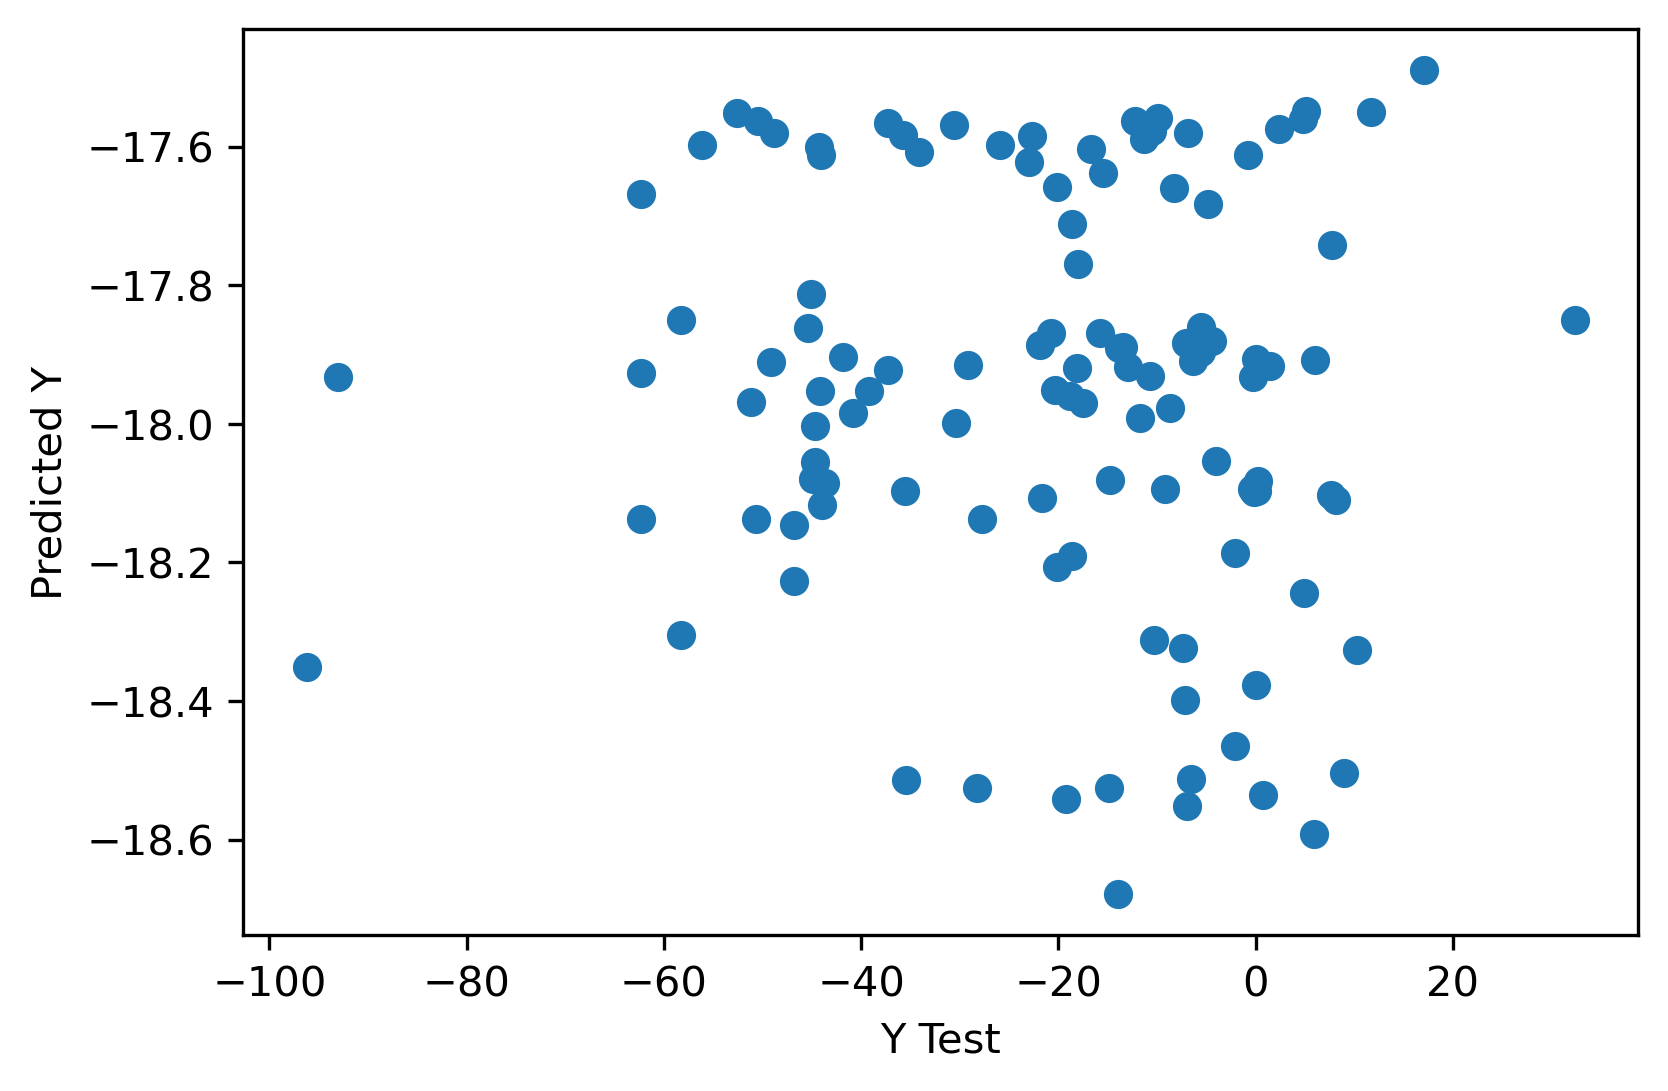

In [43]:
X_train, X_test, y_train, y_test = train_test_split(smell_X, smell_y, test_size=0.2)
lm = LinearRegression()
lm.fit(X_train, y_train)

print('Coefficients: \n', lm.coef_)
predictions = lm.predict(X_test)
plt.figure(dpi=300)
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()

In [44]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 17.991539917945875
MSE: 520.8665517074645
RMSE: 22.822500995891414


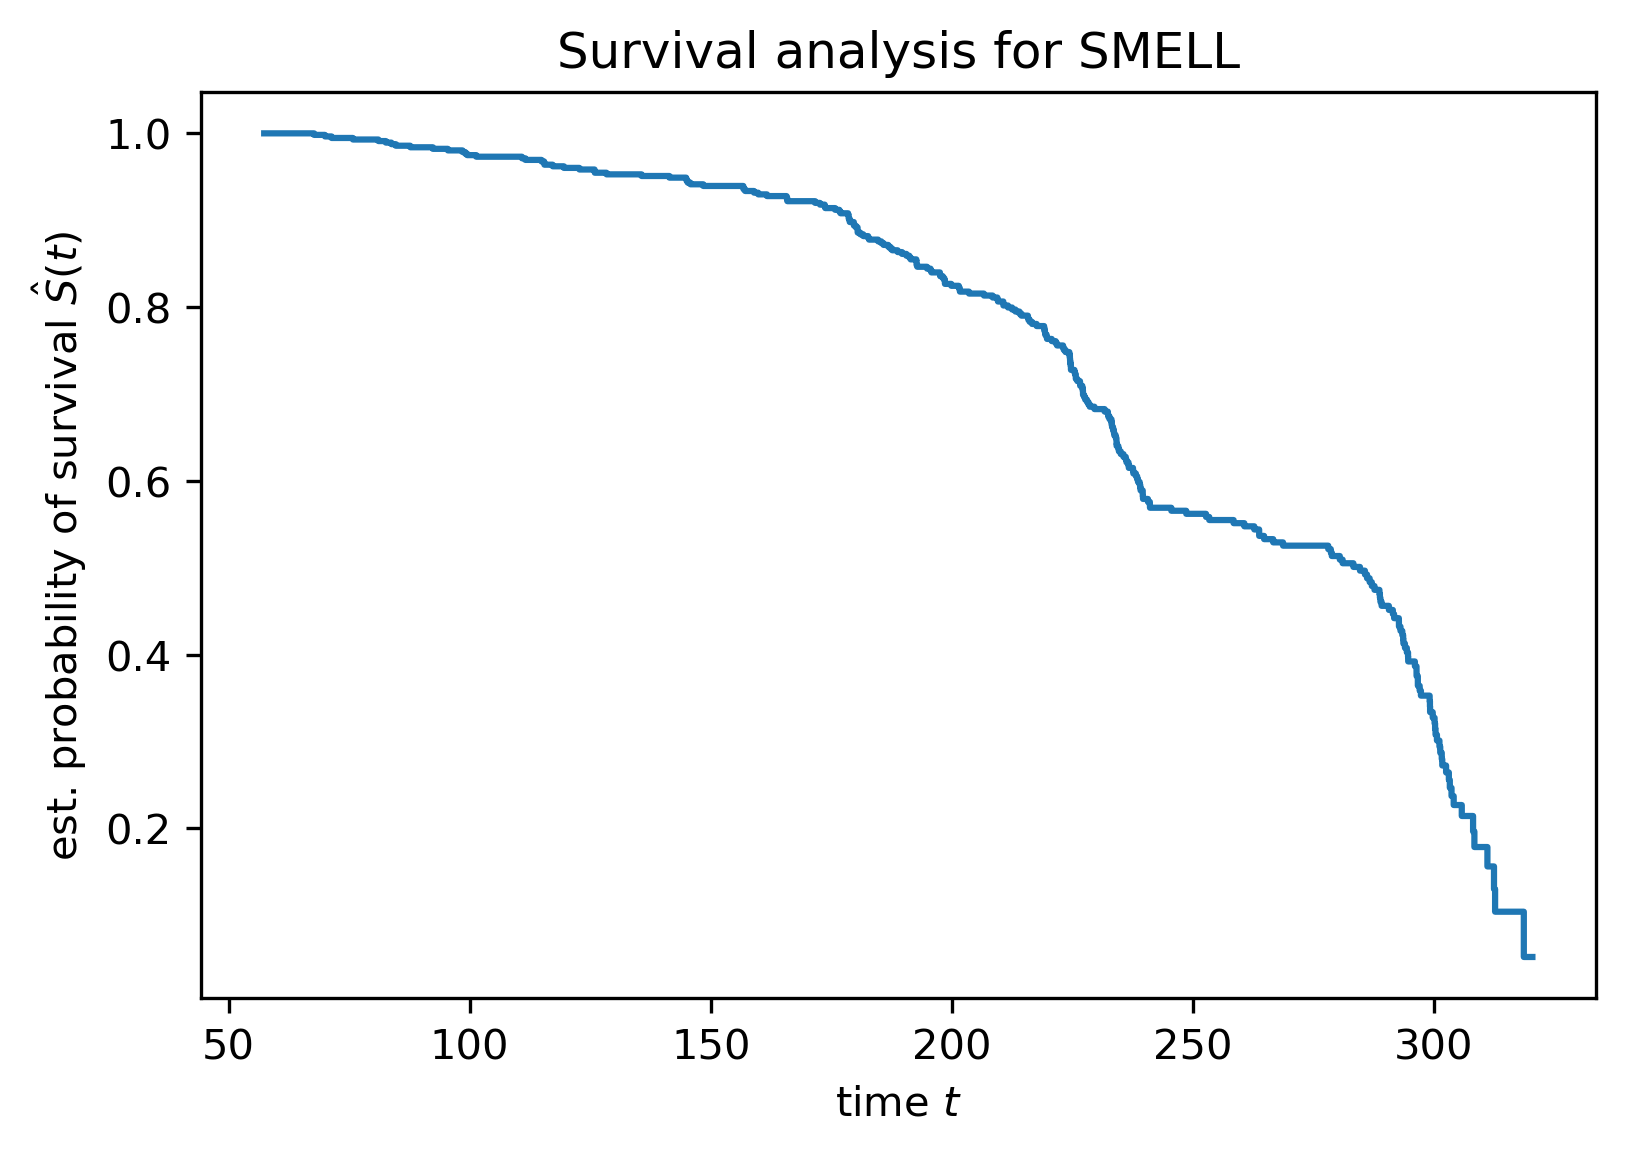

In [45]:
time, survival_prob = kaplan_meier_estimator(smell_df["Status"], smell_df["DurationInDays"])
plt.figure(dpi=300)
plt.step(time, survival_prob, where="post")
plt.title("Survival analysis for SMELL")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

In [46]:
# study for taste
taste_X = taste_df[['DurationInDays']]
taste_y = taste_df['Taste_current'] - taste_df['Taste_before_illness']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(taste_X, taste_y, test_size=0.2)
lm = LinearRegression()
lm.fit(X_train, y_train)


LinearRegression()

Coefficients: 
 [0.00549959]


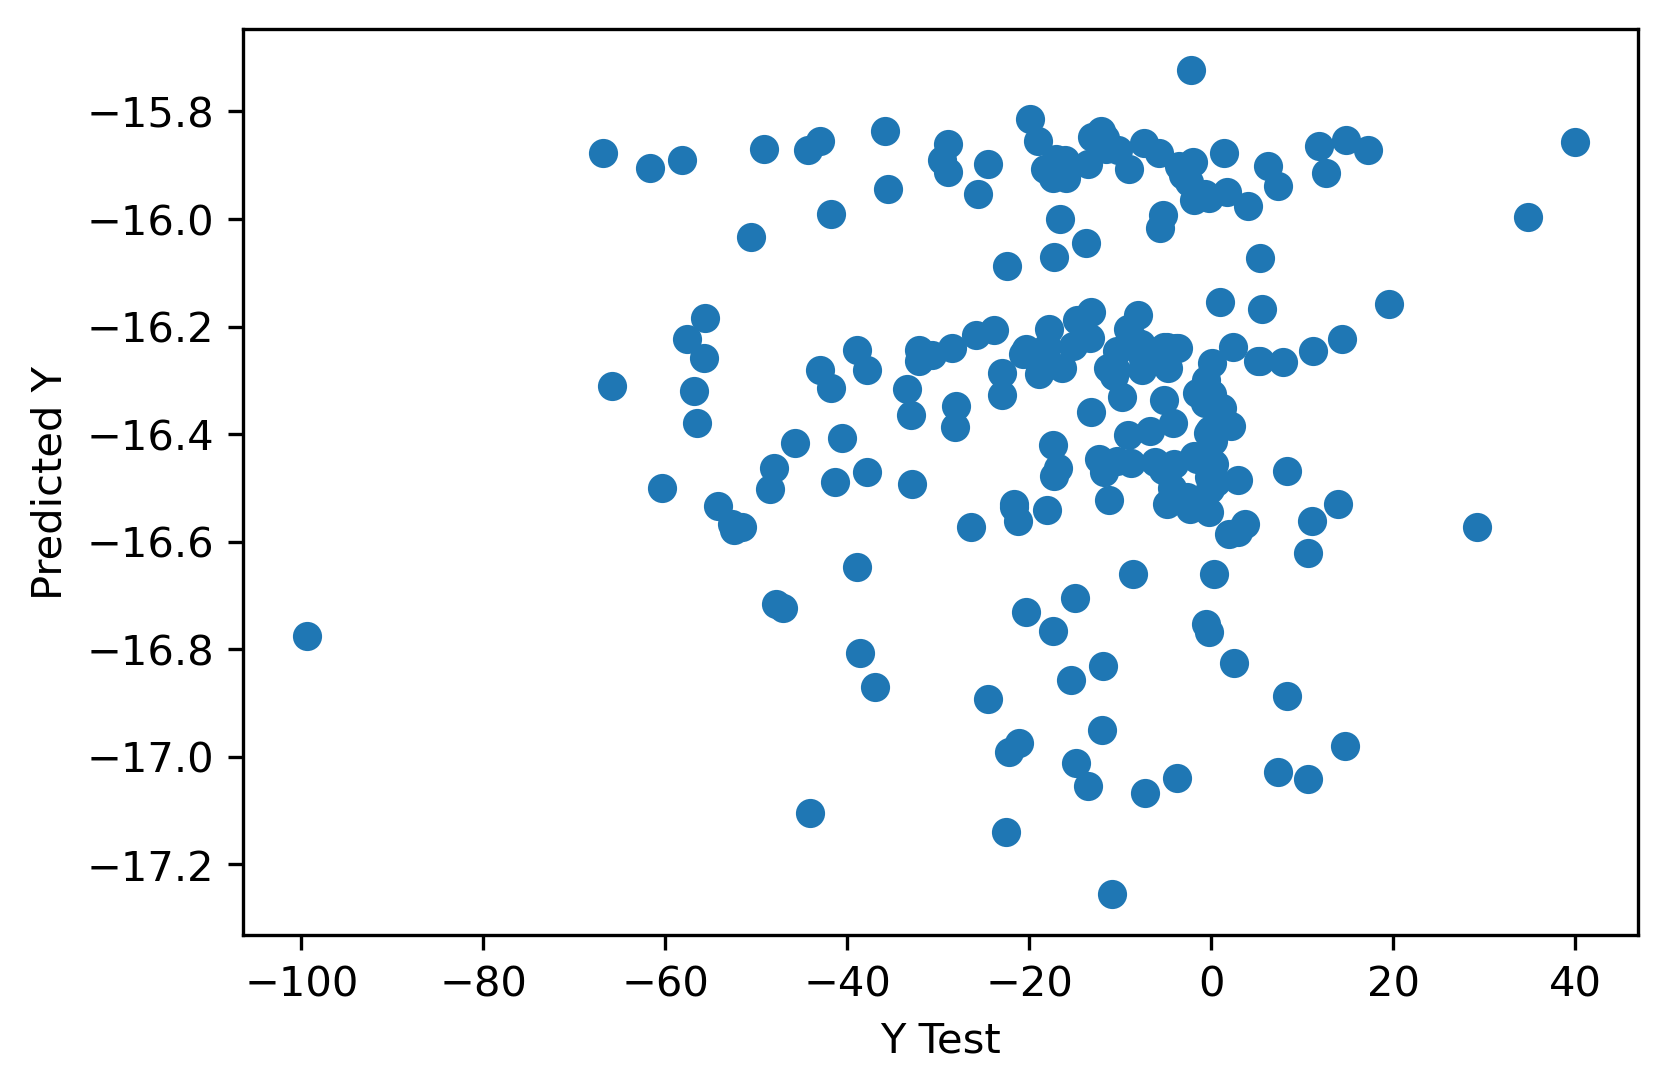

In [48]:
print('Coefficients: \n', lm.coef_)
predictions = lm.predict(X_test)
plt.figure(dpi=300)
plt.scatter(y_test, predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')
plt.show()


In [49]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 16.136516785360676
MSE: 422.60950042195896
RMSE: 20.557468239595043


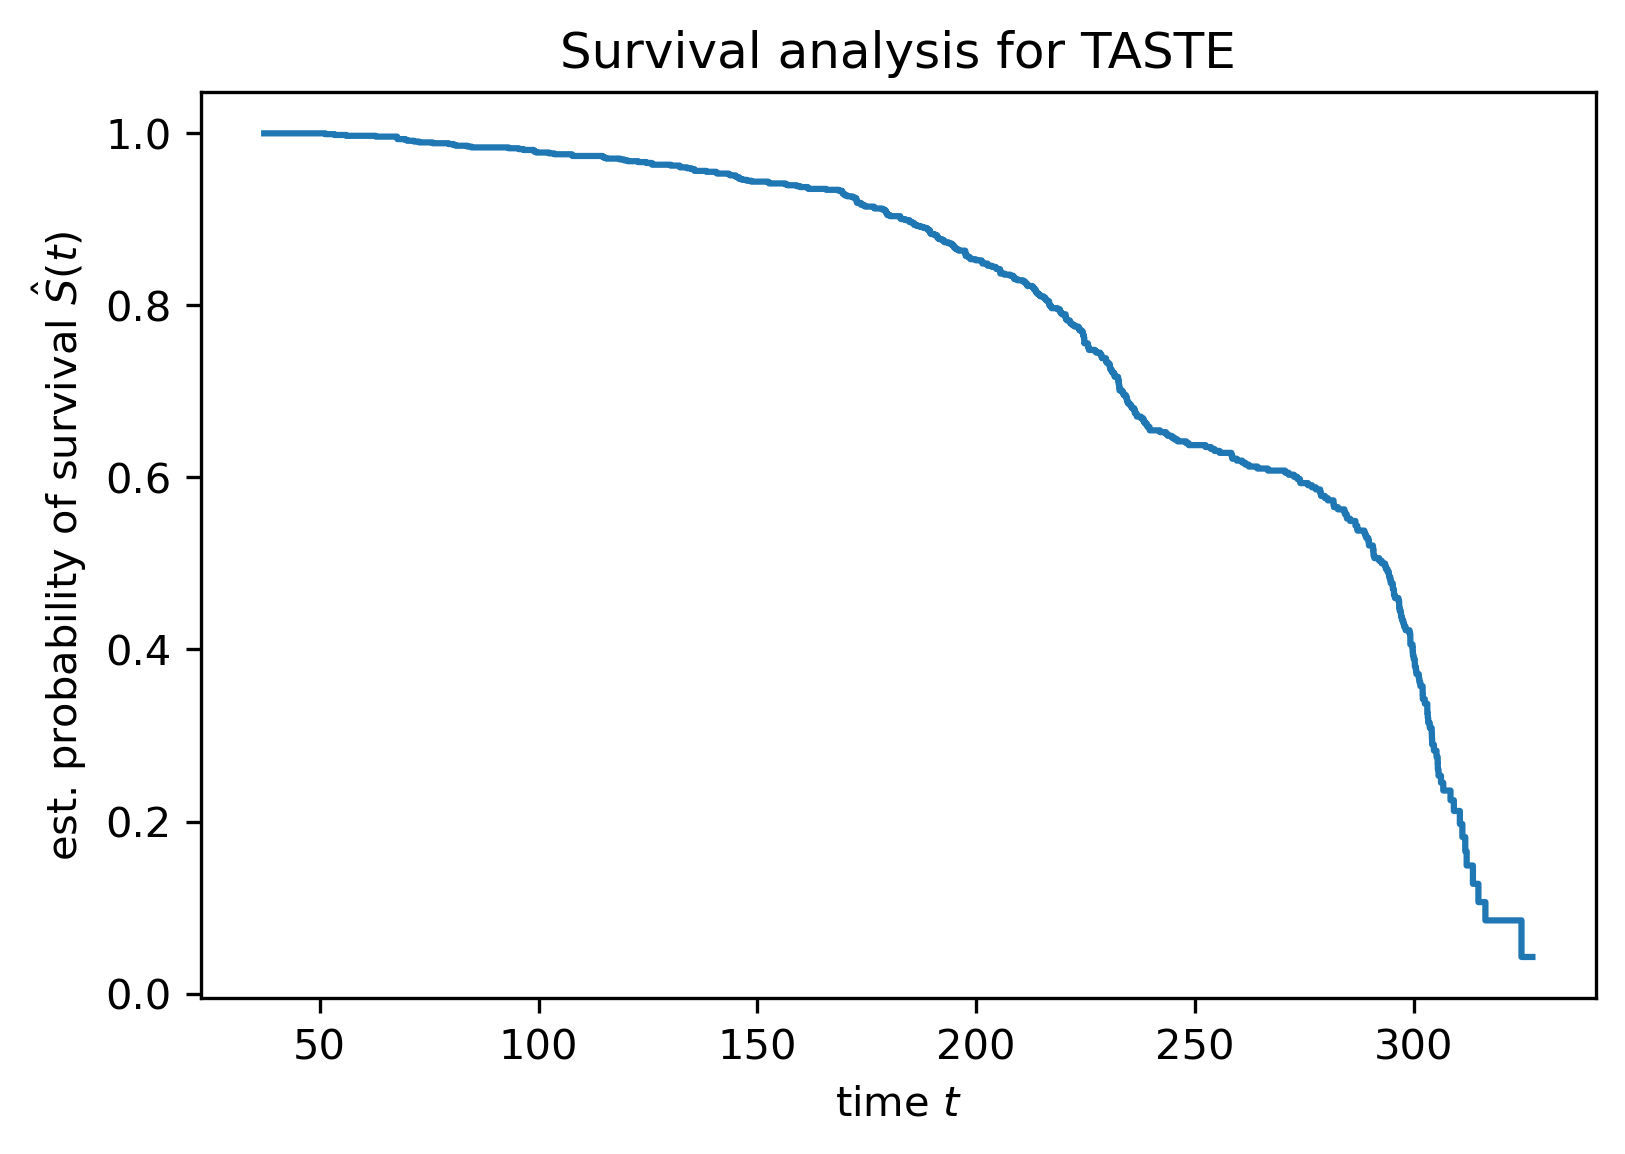

In [50]:
time, survival_prob = kaplan_meier_estimator(taste_df["Status"], taste_df["DurationInDays"])
plt.figure(dpi=300)
plt.step(time, survival_prob, where="post")
plt.title("Survival analysis for TASTE")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()